# CSC420 Assignment 4 Implementation Task

In [2]:
import matplotlib.pyplot as plt
import scipy
import cv2
import numpy as np
import math
from scipy.special import softmax
from sklearn import preprocessing

In [3]:
def get_image(path, coloring=cv2.IMREAD_GRAYSCALE):
    raw_image = cv2.imread(path)
    rgb_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
    grey_image = cv2.imread(path, coloring)
    # plt.imshow(raw_image, vmin=0, vmax=255)
    # plt.imshow
    return rgb_image, grey_image

In [4]:
def label_points(image, points):
    plt.imshow(image, cmap='gray')
    plt.scatter(points[0], points[1], s=5, color='blue')
    plt.show()
    return None

In [5]:
def find_matrix(pairs=5, p1=None, p2=None):
    A = np.zeros(shape=(2 * pairs, 9), dtype=float)
    for i in range(pairs):
        # For odd rows 
        odd =2*i
        A[odd][0], A[odd][1] = p1[0][i], p1[1][i] # x_1, y_1
        A[odd][2] = 1 # 1
        A[odd][6] = - p2[0][i] *  p1[0][i] # - x_1' * x_1
        A[odd][7] = -  p2[0][i] * p1[1][i] # - x_1' * y_1
        A[odd][8] = -  p2[0][i] # - x_1'

        # For even rows 
        even = odd + 1
        A[even][3], A[even][4] = p1[0][i], p1[1][i] # x_1, y_1
        A[even][5] = 1 # 1
        A[even][6] = - p2[1][i] *  p1[0][i] # - y_1' * x_1
        A[even][7] = -  p2[1][i] * p1[1][i] # - y_1' * y_1
        A[even][8] = -  p2[1][i] # - y_1'
    return A

(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x1c24802c5b0>)

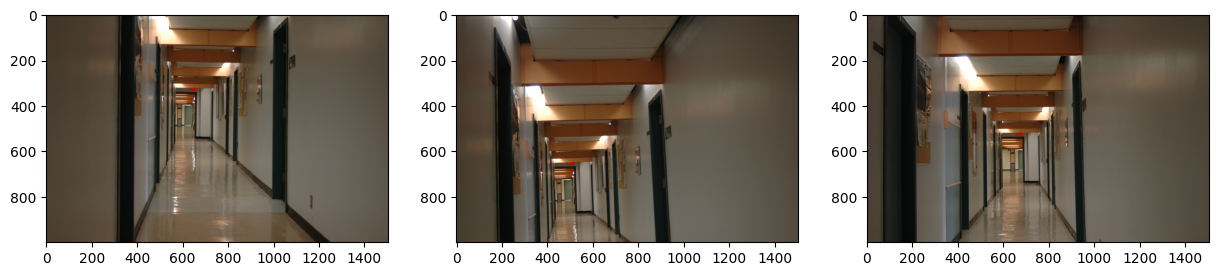

In [6]:
hallway_1, hallway_1_grey = get_image('hallway_images/hallway1.jpg')
hallway_2, hallway_2_grey = get_image('hallway_images/hallway2.jpg')
hallway_3, hallway_3_grey = get_image('hallway_images/hallway3.jpg')
plt.figure(figsize=(15,15))
plt.subplot(1,3,1), plt.imshow(hallway_1)
plt.subplot(1,3,2), plt.imshow(hallway_2)
plt.subplot(1,3,3), plt.imshow(hallway_3)

In [7]:
# Hyperparameters
no_pairs = 5

## CASE I (right wall 1 ~ 2)

[850 942 843 946 994]
[254 268 642 392  75]


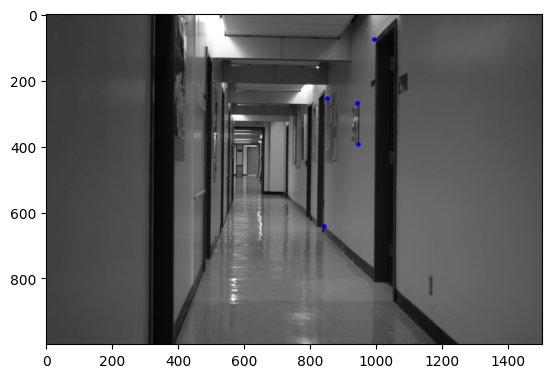

In [8]:
points_1_1 = [[850, 254], [942, 268], [843, 642], [946, 392], [994, 75]]
points_1_1 = np.array(points_1_1)
points_1_1= points_1_1.transpose((1, 0))
print(points_1_1[0])
print(points_1_1[1])
label_points(hallway_1_grey, points_1_1)

[708 721 805 812 840]
[576 958 575 704 395]


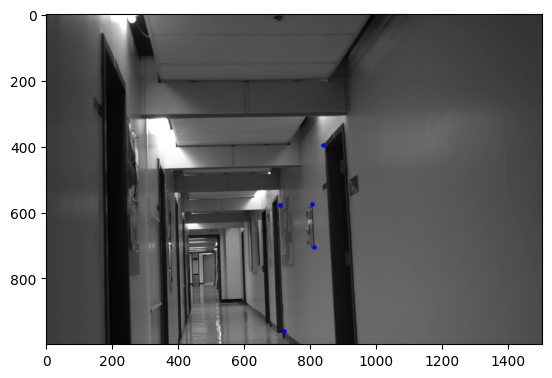

In [9]:
points_1_2 = [[708, 576], [721, 958], [805, 575], [812, 704], [840, 395]]
points_1_2 = np.array(points_1_2)
points_1_2= points_1_2.transpose((1, 0))
print(points_1_2[0])
print(points_1_2[1])
label_points(hallway_2_grey, points_1_2)

In [10]:
A = find_matrix(pairs=no_pairs, p1=points_1_1, p2=points_1_2)
B = np.matmul(A.T, A)
print(A)
np.savetxt('A.csv', A, delimiter=',')

[[ 8.50000e+02  2.54000e+02  1.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00 -6.01800e+05 -1.79832e+05 -7.08000e+02]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  8.50000e+02  2.54000e+02
   1.00000e+00 -4.89600e+05 -1.46304e+05 -5.76000e+02]
 [ 9.42000e+02  2.68000e+02  1.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00 -6.79182e+05 -1.93228e+05 -7.21000e+02]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  9.42000e+02  2.68000e+02
   1.00000e+00 -9.02436e+05 -2.56744e+05 -9.58000e+02]
 [ 8.43000e+02  6.42000e+02  1.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00 -6.78615e+05 -5.16810e+05 -8.05000e+02]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  8.43000e+02  6.42000e+02
   1.00000e+00 -4.84725e+05 -3.69150e+05 -5.75000e+02]
 [ 9.46000e+02  3.92000e+02  1.00000e+00  0.00000e+00  0.00000e+00
   0.00000e+00 -7.68152e+05 -3.18304e+05 -8.12000e+02]
 [ 0.00000e+00  0.00000e+00  0.00000e+00  9.46000e+02  3.92000e+02
   1.00000e+00 -6.65984e+05 -2.75968e+05 -7.04000e+02]
 [ 9.94000e+02  7.50000e

In [11]:
eig_val, eig_vec = np.linalg.eig(B)
min_index = np.where(eig_val == np.min(eig_val))[0]

h = eig_vec[:, min_index]
print(eig_val)
print(h)

[5.02928980e+12 1.71341532e+11 4.72758642e+06 1.96663410e+05
 1.53077012e+05 8.07250870e+03 1.33966054e+02 4.01360234e-04
 2.70767909e-06]
[[-1.24638932e-03]
 [ 1.29654860e-03]
 [ 8.92992722e-01]
 [-6.37662507e-04]
 [ 8.85906454e-04]
 [ 4.50064233e-01]
 [-1.74762076e-06]
 [ 1.53435821e-06]
 [ 1.32610106e-03]]


In [12]:
rslt = np.matmul(A, h)
M = h.reshape((3,3))
# print(rslt)
# print(h)
print(M)

estimated = []
for i in range(no_pairs):
    src = np.array( [points_1_1[0][i], points_1_1[1][i], 1])
    dst = np.array( [points_1_2[0][i], points_1_2[1][i], 1])
    est = np.matmul(M, src)
    est /= est[2]
    estimated.append(est[:2])
estimated = np.array(estimated).transpose(1,0)
print(estimated.shape)
plt.subplot(1,2,1), plt.scatter(x=points_1_2[0], y=estimated[0])
plt.subplot(1,2,2), plt.scatter(x=points_1_2[1], y=estimated[1])
# print(rslt)

[[-1.24638932e-03  1.29654860e-03  8.92992722e-01]
 [-6.37662507e-04  8.85906454e-04  4.50064233e-01]
 [-1.74762076e-06  1.53435821e-06  1.32610106e-03]]


IndexError: index 3 is out of bounds for axis 0 with size 3